In [3]:
# Standard library
import os
import random
from glob import glob

# Data & computation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Computer vision
import torchvision.models as models
from torchvision import transforms
from PIL import Image

# Utilities
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
colors = ["#89CFF0", "#FF69B4", "#FFD700", "#7B68EE", "#FF4500",
          "#9370DB", "#32CD32", "#8A2BE2", "#FF6347", "#20B2AA",
          "#FF69B4", "#00CED1", "#FF7F50", "#7FFF00", "#DA70D6"]

In [4]:
metadata = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
img_dir1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/"
img_dir2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/"

def get_img_path(image_id):
    if os.path.exists(os.path.join(img_dir1, image_id + ".jpg")):
        return os.path.join(img_dir1, image_id + ".jpg")
    else:
        return os.path.join(img_dir2, image_id + ".jpg")

metadata["path"] = metadata["image_id"].apply(get_img_path)


In [6]:
metadata.isnull().sum() / len(metadata) * 100

lesion_id       0.000000
image_id        0.000000
dx              0.000000
dx_type         0.000000
age             0.569146
sex             0.000000
localization    0.000000
path            0.000000
dtype: float64

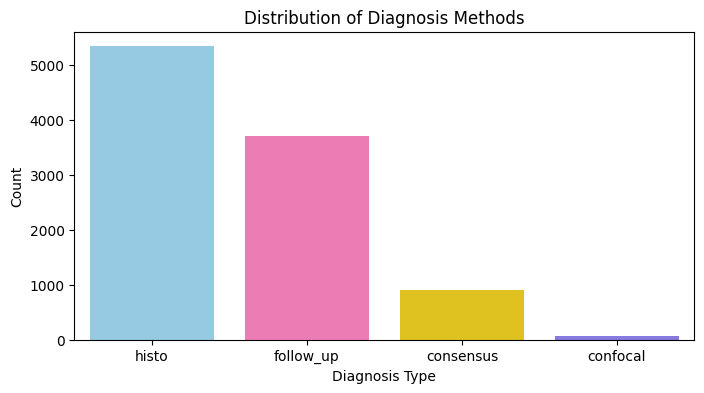

In [5]:
plt.figure(figsize=(8, 4))
sns.countplot(x='dx_type', data=metadata, order=metadata['dx_type'].value_counts().index, palette = colors)
plt.title("Distribution of Diagnosis Methods")
plt.xlabel("Diagnosis Type")
plt.ylabel("Count")
plt.show()

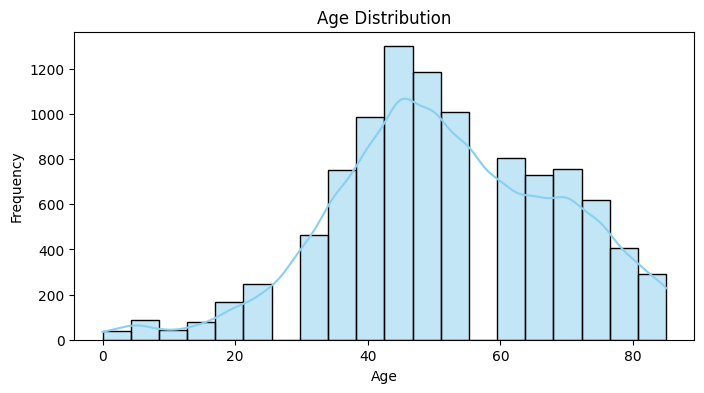

In [6]:
plt.figure(figsize=(8, 4))
sns.histplot(metadata['age'], bins=20,color=colors[0], kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

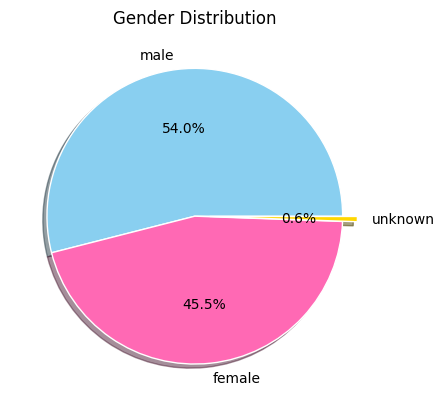

In [7]:
plt.pie(metadata['sex'].value_counts(),labels = metadata['sex'].unique(),colors = colors,
           explode=(0,0,0.1),shadow=True,wedgeprops={'edgecolor':'white'}, autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.show()

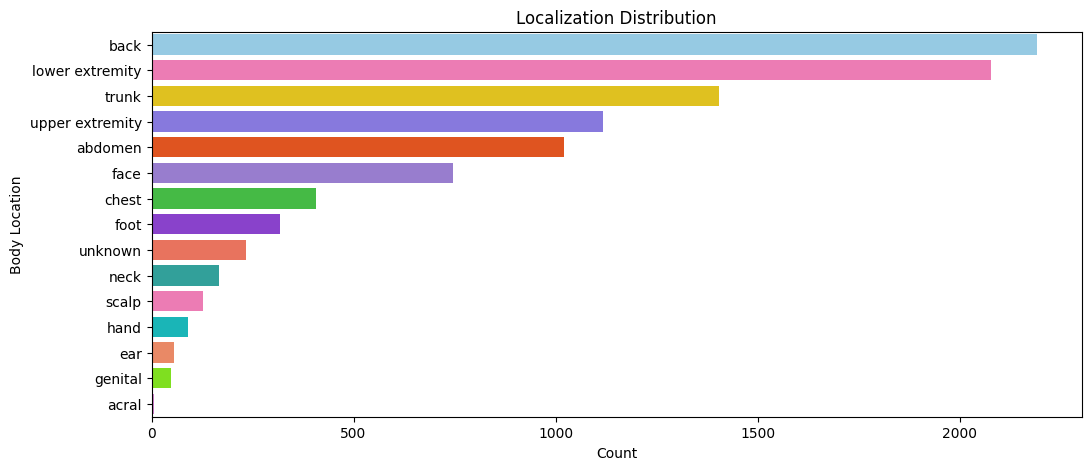

In [8]:
plt.figure(figsize=(12, 5))
sns.countplot(y='localization', data=metadata, order=metadata['localization'].value_counts().index, palette = colors)
plt.title("Localization Distribution")
plt.xlabel("Count")
plt.ylabel("Body Location")
plt.show()

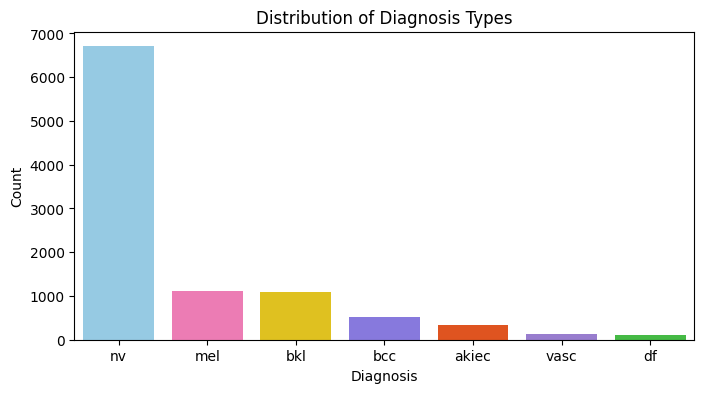

In [9]:
plt.figure(figsize=(8, 4))
sns.countplot(x='dx', data=metadata, order=metadata['dx'].value_counts().index,palette=colors)
plt.title("Distribution of Diagnosis Types")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()

In [9]:
label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
metadata['label'] = metadata['dx'].map(lambda x: label_names.index(x))

print("Imbalanced dataset distribution:")
print(metadata['label'].value_counts())

oversample_rates = [15, 10, 5, 50, 5, 1, 40]

dfs = [metadata[metadata['label'] == i] for i in range(len(label_names))]

balanced_dfs = [
    pd.concat([df_class] * rate, ignore_index=True) if rate > 0 else df_class
    for df_class, rate in zip(dfs, oversample_rates)
]

metadata_balanced = pd.concat(balanced_dfs, ignore_index=True)

print("Balanced dataset distribution:")
print(metadata_balanced['label'].value_counts().sort_index())


Imbalanced dataset distribution:
label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64
Balanced dataset distribution:
label
0    4905
1    5140
2    5495
3    5750
4    5565
5    6705
6    5680
Name: count, dtype: int64


In [10]:
label_sex = LabelEncoder()
metadata['sex'] = label_sex.fit_transform(metadata['sex'])

label_loc = LabelEncoder()
metadata['localization'] = label_loc.fit_transform(metadata['localization'])


In [11]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,1,11,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,1,11,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,1,11,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,1,11,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,1,4,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,2


In [12]:
input_size = 224
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(), 
    transforms.Normalize(norm_mean, norm_std)
])

val_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)), 
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

train_df, test_df = train_test_split(metadata_balanced, test_size=0.2, random_state=42, stratify=metadata_balanced['label'])
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['label'])

In [13]:
class SkinDataset(Dataset):
   def __init__(self, dataframe, transform=None):
       self.df = dataframe.reset_index(drop=True)
       self.image_paths = dataframe['path'].values
       self.labels = dataframe['label'].values
       self.transform = transform
   
   def __len__(self):
       return len(self.df)
   
   def __getitem__(self, idx):
       image_path = self.image_paths[idx] 
       label = self.labels[idx]           
       
       image = Image.open(image_path)
       
       if self.transform:
           image = self.transform(image)
       
       return image, label

train_dataset = SkinDataset(train_df, transform=train_transform)
val_dataset = SkinDataset(val_df, transform=val_transform)
test_dataset = SkinDataset(test_df, transform=val_transform)

In [14]:
torch.backends.cudnn.benchmark = True 

train_loader = DataLoader(
   train_dataset, 
   batch_size=128,             
   shuffle=True, 
   num_workers=4,             
   pin_memory=True,            
   persistent_workers=True,    
   prefetch_factor=4          
)

val_loader = DataLoader(
   val_dataset, 
   batch_size=256,             
   shuffle=False, 
   num_workers=4,             
   pin_memory=True,            
   persistent_workers=True,
   prefetch_factor=4
)

test_loader = DataLoader(
   test_dataset, 
   batch_size=256,             
   shuffle=False, 
   num_workers=4,              
   pin_memory=True,
   persistent_workers=True,    
   prefetch_factor=4
)

#ResNet model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 7)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 217MB/s]


In [15]:
def train_cnn_model(
    model,
    train_loader, 
    val_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=50,
    patience=10):
    
    print(f"Training {model.__class__.__name__} for {num_epochs} epochs (patience: {patience})")
    print("-" * 60)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    best_epoch = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            current_loss = train_loss / (progress_bar.n + 1)
            current_acc = (train_correct / train_total) * 100
            progress_bar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'accuracy': f'{current_acc:.2f}%'
            })

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate final metrics
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)

        # Store metrics
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accs.append(train_acc * 100)
        val_accs.append(val_acc * 100)

        # Print metrics
        print(f'Epoch {epoch+1}: loss: {train_loss_avg:.4f} - accuracy: {train_acc*100:.2f}% - val_loss: {val_loss_avg:.4f} - val_accuracy: {val_acc*100:.2f}%')

        # Early stopping check
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            best_epoch = epoch + 1
            print('Validation loss improved. Best model updated.')
        else:
            patience_counter += 1
            print(f'No improvement. Patience: {patience_counter}/{patience}')

            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'Best model from epoch {best_epoch} loaded')

    # Test evaluation
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = (test_correct / test_total) * 100
    test_loss_avg = test_loss / len(test_loader)

    print(f"\nTest Results:")
    print(f"Test Loss: {test_loss_avg:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")

    # Generate and display confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names)
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Generate and display classification report
    report = classification_report(all_labels, all_predictions, target_names=label_names, output_dict=True, zero_division=0)
    report_text = classification_report(all_labels, all_predictions, target_names=label_names, zero_division=0)

    # Print classification report
    print("\nClassification Report:")
    print("="*50)
    print(report_text)
    print("="*50)

    # Print final summary
    print(f"Total epochs trained: {len(train_losses)}")
    print(f"Best epoch: {best_epoch}")
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Best train accuracy: {max(train_accs):.2f}%")
    print(f"Best val accuracy: {max(val_accs):.2f}%")
    print(f"Final test accuracy: {test_acc:.2f}%")

    return train_losses, val_losses, train_accs, val_accs, test_loss_avg, test_acc

Training ResNet for 30 epochs (patience: 10)
------------------------------------------------------------


Epoch 1/30: 100%|██████████| 184/184 [05:47<00:00,  1.89s/it, loss=0.6711, accuracy=74.88%]


Epoch 1: loss: 0.6711 - accuracy: 74.88% - val_loss: 0.4674 - val_accuracy: 82.49%
Validation loss improved. Best model updated.


Epoch 2/30: 100%|██████████| 184/184 [04:57<00:00,  1.61s/it, loss=0.3897, accuracy=85.27%]


Epoch 2: loss: 0.3897 - accuracy: 85.27% - val_loss: 0.2951 - val_accuracy: 88.37%
Validation loss improved. Best model updated.


Epoch 3/30: 100%|██████████| 184/184 [04:55<00:00,  1.61s/it, loss=0.3105, accuracy=88.30%]


Epoch 3: loss: 0.3105 - accuracy: 88.30% - val_loss: 0.3419 - val_accuracy: 86.86%
No improvement. Patience: 1/10


Epoch 4/30: 100%|██████████| 184/184 [04:57<00:00,  1.61s/it, loss=0.2529, accuracy=90.52%]


Epoch 4: loss: 0.2529 - accuracy: 90.52% - val_loss: 0.3111 - val_accuracy: 88.52%
No improvement. Patience: 2/10


Epoch 5/30: 100%|██████████| 184/184 [04:56<00:00,  1.61s/it, loss=0.2104, accuracy=92.16%]


Epoch 5: loss: 0.2104 - accuracy: 92.16% - val_loss: 0.2817 - val_accuracy: 89.63%
Validation loss improved. Best model updated.


Epoch 6/30: 100%|██████████| 184/184 [04:56<00:00,  1.61s/it, loss=0.1935, accuracy=92.55%]


Epoch 6: loss: 0.1935 - accuracy: 92.55% - val_loss: 0.1725 - val_accuracy: 93.54%
Validation loss improved. Best model updated.


Epoch 7/30: 100%|██████████| 184/184 [04:55<00:00,  1.61s/it, loss=0.1660, accuracy=93.88%]


Epoch 7: loss: 0.1660 - accuracy: 93.88% - val_loss: 0.1875 - val_accuracy: 93.02%
No improvement. Patience: 1/10


Epoch 8/30: 100%|██████████| 184/184 [04:55<00:00,  1.61s/it, loss=0.1474, accuracy=94.67%]


Epoch 8: loss: 0.1474 - accuracy: 94.67% - val_loss: 0.1442 - val_accuracy: 94.72%
Validation loss improved. Best model updated.


Epoch 9/30: 100%|██████████| 184/184 [04:55<00:00,  1.61s/it, loss=0.1446, accuracy=94.73%]


Epoch 9: loss: 0.1446 - accuracy: 94.73% - val_loss: 0.2522 - val_accuracy: 90.80%
No improvement. Patience: 1/10


Epoch 10/30: 100%|██████████| 184/184 [04:55<00:00,  1.61s/it, loss=0.1183, accuracy=95.61%]


Epoch 10: loss: 0.1183 - accuracy: 95.61% - val_loss: 0.2434 - val_accuracy: 91.58%
No improvement. Patience: 2/10


Epoch 11/30: 100%|██████████| 184/184 [04:55<00:00,  1.61s/it, loss=0.1119, accuracy=95.85%]


Epoch 11: loss: 0.1119 - accuracy: 95.85% - val_loss: 0.2313 - val_accuracy: 91.59%
No improvement. Patience: 3/10


Epoch 12/30: 100%|██████████| 184/184 [04:55<00:00,  1.61s/it, loss=0.1019, accuracy=96.16%]


Epoch 12: loss: 0.1019 - accuracy: 96.16% - val_loss: 0.1493 - val_accuracy: 95.01%
No improvement. Patience: 4/10


Epoch 13/30: 100%|██████████| 184/184 [04:55<00:00,  1.61s/it, loss=0.0906, accuracy=96.70%]


Epoch 13: loss: 0.0906 - accuracy: 96.70% - val_loss: 0.1494 - val_accuracy: 94.44%
No improvement. Patience: 5/10


Epoch 14/30: 100%|██████████| 184/184 [04:56<00:00,  1.61s/it, loss=0.0895, accuracy=96.82%]


Epoch 14: loss: 0.0895 - accuracy: 96.82% - val_loss: 0.2336 - val_accuracy: 91.77%
No improvement. Patience: 6/10


Epoch 15/30: 100%|██████████| 184/184 [04:55<00:00,  1.61s/it, loss=0.0873, accuracy=96.78%]


Epoch 15: loss: 0.0873 - accuracy: 96.78% - val_loss: 0.1070 - val_accuracy: 96.34%
Validation loss improved. Best model updated.


Epoch 16/30: 100%|██████████| 184/184 [04:55<00:00,  1.60s/it, loss=0.0715, accuracy=97.25%]


Epoch 16: loss: 0.0715 - accuracy: 97.25% - val_loss: 0.1272 - val_accuracy: 95.90%
No improvement. Patience: 1/10


Epoch 17/30: 100%|██████████| 184/184 [04:55<00:00,  1.61s/it, loss=0.0711, accuracy=97.55%]


Epoch 17: loss: 0.0711 - accuracy: 97.55% - val_loss: 0.1238 - val_accuracy: 95.57%
No improvement. Patience: 2/10


Epoch 18/30: 100%|██████████| 184/184 [04:55<00:00,  1.61s/it, loss=0.0683, accuracy=97.58%]


Epoch 18: loss: 0.0683 - accuracy: 97.58% - val_loss: 0.1686 - val_accuracy: 94.14%
No improvement. Patience: 3/10


Epoch 19/30: 100%|██████████| 184/184 [04:55<00:00,  1.60s/it, loss=0.0600, accuracy=97.86%]


Epoch 19: loss: 0.0600 - accuracy: 97.86% - val_loss: 0.1708 - val_accuracy: 94.58%
No improvement. Patience: 4/10


Epoch 20/30: 100%|██████████| 184/184 [04:54<00:00,  1.60s/it, loss=0.0644, accuracy=97.66%]


Epoch 20: loss: 0.0644 - accuracy: 97.66% - val_loss: 0.1320 - val_accuracy: 96.16%
No improvement. Patience: 5/10


Epoch 21/30: 100%|██████████| 184/184 [04:55<00:00,  1.61s/it, loss=0.0652, accuracy=97.75%]


Epoch 21: loss: 0.0652 - accuracy: 97.75% - val_loss: 0.1037 - val_accuracy: 97.13%
Validation loss improved. Best model updated.


Epoch 22/30: 100%|██████████| 184/184 [04:55<00:00,  1.61s/it, loss=0.0547, accuracy=98.14%]


Epoch 22: loss: 0.0547 - accuracy: 98.14% - val_loss: 0.1249 - val_accuracy: 96.24%
No improvement. Patience: 1/10


Epoch 23/30: 100%|██████████| 184/184 [04:56<00:00,  1.61s/it, loss=0.0494, accuracy=98.30%]


Epoch 23: loss: 0.0494 - accuracy: 98.30% - val_loss: 0.0726 - val_accuracy: 97.83%
Validation loss improved. Best model updated.


Epoch 24/30: 100%|██████████| 184/184 [04:54<00:00,  1.60s/it, loss=0.0474, accuracy=98.38%]


Epoch 24: loss: 0.0474 - accuracy: 98.38% - val_loss: 0.1116 - val_accuracy: 96.84%
No improvement. Patience: 1/10


Epoch 25/30: 100%|██████████| 184/184 [04:55<00:00,  1.61s/it, loss=0.0557, accuracy=97.98%]


Epoch 25: loss: 0.0557 - accuracy: 97.98% - val_loss: 0.0939 - val_accuracy: 97.23%
No improvement. Patience: 2/10


Epoch 26/30: 100%|██████████| 184/184 [04:55<00:00,  1.60s/it, loss=0.0419, accuracy=98.46%]


Epoch 26: loss: 0.0419 - accuracy: 98.46% - val_loss: 0.1056 - val_accuracy: 97.06%
No improvement. Patience: 3/10


Epoch 27/30: 100%|██████████| 184/184 [04:55<00:00,  1.61s/it, loss=0.0471, accuracy=98.31%]


Epoch 27: loss: 0.0471 - accuracy: 98.31% - val_loss: 0.1118 - val_accuracy: 96.89%
No improvement. Patience: 4/10


Epoch 28/30: 100%|██████████| 184/184 [04:56<00:00,  1.61s/it, loss=0.0394, accuracy=98.66%]


Epoch 28: loss: 0.0394 - accuracy: 98.66% - val_loss: 0.0817 - val_accuracy: 97.55%
No improvement. Patience: 5/10


Epoch 29/30: 100%|██████████| 184/184 [04:56<00:00,  1.61s/it, loss=0.0370, accuracy=98.73%]


Epoch 29: loss: 0.0370 - accuracy: 98.73% - val_loss: 0.0870 - val_accuracy: 97.62%
No improvement. Patience: 6/10


Epoch 30/30: 100%|██████████| 184/184 [04:55<00:00,  1.60s/it, loss=0.0434, accuracy=98.52%]


Epoch 30: loss: 0.0434 - accuracy: 98.52% - val_loss: 0.0782 - val_accuracy: 97.71%
No improvement. Patience: 7/10
Best model from epoch 23 loaded

Test Results:
Test Loss: 0.0790
Test Accuracy: 97.54%


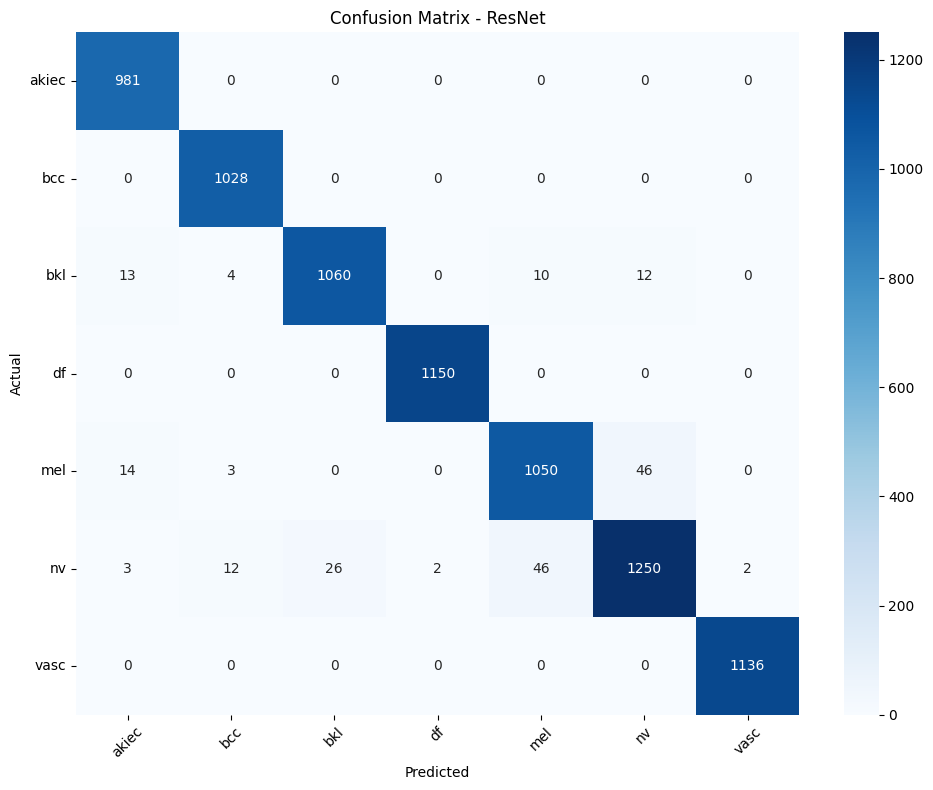


Classification Report:
              precision    recall  f1-score   support

       akiec       0.97      1.00      0.98       981
         bcc       0.98      1.00      0.99      1028
         bkl       0.98      0.96      0.97      1099
          df       1.00      1.00      1.00      1150
         mel       0.95      0.94      0.95      1113
          nv       0.96      0.93      0.94      1341
        vasc       1.00      1.00      1.00      1136

    accuracy                           0.98      7848
   macro avg       0.98      0.98      0.98      7848
weighted avg       0.98      0.98      0.98      7848

Total epochs trained: 30
Best epoch: 23
Best validation loss: 0.0726
Best train accuracy: 98.73%
Best val accuracy: 97.83%
Final test accuracy: 97.54%


In [16]:
train_losses, val_losses, train_accs, val_accs, test_loss, test_accuracy = train_cnn_model(
    model, train_loader, val_loader, test_loader, criterion, optimizer,
    num_epochs=30, patience=10
)

In [19]:
torch.save(model.state_dict(), "/kaggle/working/best_model.pth")

In [ ]:
torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
